파일 설명 : TF 2.x부터는 직관적으로 코딩하고 디버깅하기 편해졌다!!

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # 1번 GPU 사용

In [2]:
import tensorflow as tf
import cProfile # 파이썬 내장 성능 분석 도구

2025-11-24 00:10:38.314482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763910638.328440   27414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763910638.332642   27414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763910638.344144   27414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763910638.344154   27414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763910638.344156   27414 computation_placer.cc:177] computation placer alr

In [3]:
'''gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # ★ 핵심: 메모리를 한 번에 다 잡지 말고, 필요할 때마다 늘려나가라!
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


print(f"탐지된 GPU 개수: {len(gpus)}개") 
print(f"탐지된 GPU 목록: {gpus}")'''

'gpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n    try:\n        for gpu in gpus:\n            # ★ 핵심: 메모리를 한 번에 다 잡지 말고, 필요할 때마다 늘려나가라!\n            tf.config.experimental.set_memory_growth(gpu, True)\n    except RuntimeError as e:\n        print(e)\n\n\nprint(f"탐지된 GPU 개수: {len(gpus)}개") \nprint(f"탐지된 GPU 목록: {gpus}")'

설치와 기본 사용법

In [4]:
# 텐서플로 2.0에서 즉시 실행은 기본으로 활성화되어 있습니다.
tf.executing_eagerly()


True

In [5]:
x = [[2.]] #2차원 행렬(텐서) 정의 (1x1 행렬)
m = tf.matmul(x, x) # 행렬 곱 수행
print(f"hello, {m.numpy()}") # .numpy()를 붙이면 tf.Tensor(...) 껍데기를 벗기고 숫자만 보여줌 (ndarray 반환)

hello, [[4.]]


I0000 00:00:1763910639.978241   27414 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22323 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [6]:
a = tf.constant([[1,2],
                 [3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [7]:
# 브로드캐스팅(Broadcasting) 지원 -> 스칼라 1을 [[1,1],[1,1]]로 변환시켜 연산
b = tf.add(a, 1)
print(b)
# 연산자 오버로딩 지원 -> 원소별 곱셈 예시
print(a * b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:
# NumPy값 사용 -> 하지만 Numpy 연산은 CPU에서 돌고 Tensor는 GPU에서 돈다는 점 주의
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


동적인 제어 흐름 : 텐서플로우라고 해서 특별한 제어문이 있는 게 아니라, 그냥 파이썬 짜듯이 로직 짜면 알아서 돌아갑니다.

In [9]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [10]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


# 즉시 훈련
그래디언트 계산하기 : 📌 3단 요약
1. 녹화 (Record): with tf.GradientTape() as tape: 블록 안에서 일어나는 모든 수학 연산을 테이프에 기록합니다.

2. 미분 (Calculate): 기록된 테이프를 되감기해서 기울기(Gradient)를 계산합니다. (tape.gradient())

3. 폐기 (Discard): 계산이 끝나면 메모리 절약을 위해 테이프는 자동으로 쓰레기통에 버려집니다. (1회용)

In [11]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad.numpy())  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32) 미분값 2w에 1대입한 결과

[[2.]]


Model training : 표준 MNIST 손글씨 분류를 위한 다층 모델을 생성, 즉시 실행 환경에서 훈련가능한 그래프를 생성하기 위한 옵티마이저(optimizer)와 층 API를 보여줌

In [12]:
# mnist 데이터 가져오기(RAM) 및 포맷 맞추기 (학습용),(테스트용) -> 테스트용은 _로 안가져옴
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

# 통짜 데이터(6만 개)를 '하나씩 꺼내 쓸 수 있는 스트림(Stream)' 형태로 만듭니다.
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32), # 이미지 전처리 (변환) -> 차원 추가(newaxis), 정규화(/255), 형변환(float32)
   tf.cast(mnist_labels,tf.int64))) # label 형변환(int64)
dataset = dataset.shuffle(1000).batch(32) # 데이터를 무작위로 섞기(buffer크기 1000), 이미지 32장을 한 묶음(Batch)으로

In [13]:
# 모델 생성
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10) # Torch와 다르게 입력 채널 수 적을 필요 X
])

/home/lab602/miniconda3/envs/tutorial/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# 즉시 실행에서는 훈련을 하지 않아도 모델을 사용하고 결과를 점검할 수 있습니다
for images,labels in dataset.take(1):
  print("로짓: ", mnist_model(images[0:1]).numpy())

I0000 00:00:1763910641.760404   27414 cuda_dnn.cc:529] Loaded cuDNN version 90300


로짓:  [[ 0.00943391 -0.01433963  0.00511956 -0.03268095 -0.05454128  0.00045946
   0.01094687  0.0227422   0.00468264 -0.04966153]]


2025-11-24 00:10:41.962314: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# 케라스 모델은 자체적인 훈련 메서드(fit)을 포함하고 있지만 때로는 좀 더 수정할 필요가 있습니다. 다음은 즉시 실행을 활용한 반복적인 훈련의 예
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

model.fit()과 같은 코드 : [순전파(Forward) $\rightarrow$ 손실 계산(Loss) $\rightarrow$ 역전파(Backward) $\rightarrow$ 가중치 업데이트(Update)]

In [16]:
def train_step(images, labels):
  with tf.GradientTape() as tape: # 연산 기록 시작
    logits = mnist_model(images, training=True) # Forward Pass, 학습모드

    # 결과의 형태를 확인하기 위해서 단언문(Debugging) 추가
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits) # Loss Calculation

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables) # Backpropagation
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables)) # Gradient Descent

In [17]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('에포크 {} 종료'.format(epoch))

In [18]:
train()

2025-11-24 00:11:28.627019: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


에포크 0 종료
에포크 1 종료
에포크 2 종료


2025-11-24 00:12:59.948631: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0, 0.5, 'Loss [entropy]')

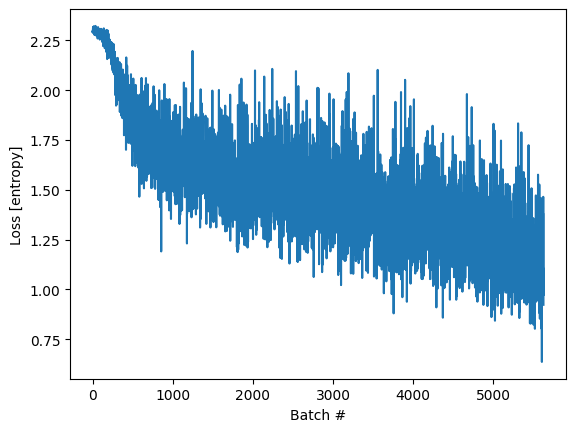

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')